Now we have the raw data produced. Below, we load the csv and print a few lines. We will have time numbers, the particular keypoints, for each person and the x and y coordinates. We will now process the interpersonal distance between the two persons ID0 and ID1 (which will correspond to the same persons if the two persons are in time for the entire video). 

In [1]:
import pandas as pd
import glob as glob


inputfollayer1= '../data_sampledatatracked_afterSTEP1/'
# check for a csv in the outputfolder using glob
layeronedat = glob.glob(inputfollayer1 + '*.csv')
print(layeronedat)
ts = pd.read_csv(layeronedat[0])
ts.head()


['../data_sampledatatracked_afterSTEP1\\test_keypoints_data_layer1.csv']


,frame,person,keypoint,x,y
0,1140,0,0,1220.983276,931.566467
1,1140,0,1,1255.567627,952.745117
2,1140,0,2,1256.549927,897.176514
3,1140,0,3,1378.511597,975.737061
4,1140,0,4,0.000000,0.000000


# Bounding boxes and social proximity

How would we generate the distance between persons of the above data structure? The first thing we need to do, is to compute single position that somehow summarizes the position of all keypoints of the individual. We could for example say, the position of the individual's body is the center of a bounding box, such that the bounding box just outlines the edges of the individual body segments. Or we could say, give me all the keypoint locations and compute the average x and y positions, such that we have the center of mass of the individual.

The below routine goes over each file again and now computes for each time a bounding box (all the maxima and minima of each dimensions based on the keypoints) and the centroid of that bounding box. We also generate a center of mass, which is the average location. We only do this for the upper body. So for each time.

We also add a time variable in seconds, which we base on the timerate which we check with each video.

For smoothing we use a [OneEurofilter](https://jaantollander.com/post/noise-filtering-using-one-euro-filter/).

## social distance measures (timeseries data)
- we also compute a smoothness measure between the distance measures
## Extra variables
We will also add some extra variables:
- midpoint between shoulder for person 1 and 2
- distance between shoulder midpoints (also a smoothed version)
- wrist positions
- left hand speed person 1 and 2 (also a smoothed version)
- right hand speed person 1 and 2 (also a smoothed version)

## To do: 
- apply OneEuroFilter


In [2]:
!pip install --upgrade pandas


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
import math
from bisect import bisect_left

inputfollayer1= '../data_sampledatatracked_afterSTEP1/'
outputfol = '../data_sampledatatotimeseries_afterSTEP2/'

def frame_to_time(ts):
    fps = 50

    ts["time"] = [row[1]["frame"]/fps for row in ts.iterrows()]

    return ts

## SMOOTHING
def smoothing_factor(t_e, cutoff):
      r = 2 * math.pi * cutoff * t_e
      return r / (r + 1)


def exponential_smoothing(a, x, x_prev):
      return a * x + (1 - a) * x_prev

# https://jaantollander.com/post/noise-filtering-using-one-euro-filter/
# to cite: https://github.com/jaantollander/OneEuroFilter/blob/master/README.md
class OneEuroFilter:
    def __init__(self, t0, x0, dx0=0.0, min_cutoff=1.0, beta=0.0,
                      d_cutoff=1.0):
          """Initialize the one euro filter."""
          # The parameters.
          self.min_cutoff = float(min_cutoff)
          self.beta = float(beta)
          self.d_cutoff = float(d_cutoff)
          # Previous values.
          self.x_prev = float(x0)
          self.dx_prev = float(dx0)
          self.t_prev = float(t0)

    def __call__(self, t, x):
          """Compute the filtered signal."""
          t_e = max(t - self.t_prev, 1e-6)

          # The filtered derivative of the signal.
          a_d = smoothing_factor(t_e, self.d_cutoff)
          dx = (x - self.x_prev) / t_e
          dx_hat = exponential_smoothing(a_d, dx, self.dx_prev)

          # The filtered signal.
          cutoff = self.min_cutoff + self.beta * abs(dx_hat)
          a = smoothing_factor(t_e, cutoff)
          x_hat = exponential_smoothing(a, x, self.x_prev)

          # Memorize the previous values.
          self.x_prev = x_hat
          self.dx_prev = dx_hat
          self.t_prev = t

          return x_hat
     
# Initialize filters for each signal we want to smooth
def apply_one_euro_filter(time_series, times, min_cutoff=1.0, beta=0.0):
     """Apply One Euro Filter to a time series"""
     # Pre-check inputs
     assert np.all(np.diff(times) > 0), "Time values are not strictly increasing!"
     time_series = np.nan_to_num(time_series, nan=np.nanmean(time_series))  # Replace NaNs
     times = np.nan_to_num(times, nan=np.nanmean(times))
     # Validate inputs before initializing the filter
     if np.isnan(time_series[0]) or np.isnan(times[0]):
          raise ValueError("Invalid initialization values: NaNs detected in input data.")
     f = OneEuroFilter(times[0], time_series[0], min_cutoff=min_cutoff, beta=beta)
     filtered_series = []
     for t, x in zip(times, time_series):
          try:
                filtered_series.append(f(t, x))
          except Exception as e:
                print(f"Error at t={t}, x={x}: {e}")  # Debug info
                filtered_series.append(x)  # Use original value as fallback
     return filtered_series  

# identify all layer one data
layeronedat = glob.glob(inputfollayer1 + '*.csv')

def safe_get(series):
    return series.iloc[0] if not series.empty else np.nan

# PREPROCESSING
# No longer used, as the tracking code already limits each frame to detecting max 2 people
def identify_main_people(ts):
    """Identify the two most frequently tracked people and assign them as left/right"""
    # Count times per person
    person_counts = ts.groupby('person').size()
    
    # Get the two most frequent people
    main_people = person_counts.nlargest(2).index.tolist()
    
    # Calculate average x position for these two people
    avg_positions = ts[ts['person'].isin(main_people)].groupby('person')['x'].mean()
    
    # Assign left (0) and right (1) based on x position
    person_mapping = {}
    left_person = avg_positions.idxmin()
    right_person = avg_positions.idxmax()
    person_mapping[left_person] = 0  # Left person becomes person 0
    person_mapping[right_person] = 1  # Right person becomes person 1
    
    print(f"Original person IDs: Left = {left_person}, Right = {right_person}")
    
    # Create new Dataframe with remapped people
    ts_filtered = ts[ts['person'].isin(main_people)].copy()
    ts_filtered['person'] = ts_filtered['person'].map(person_mapping)
    
    return ts_filtered
    


def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before


def assign_left_right(ts):

    min_x = np.min([val for val in ts['x'] if val != 0 ])
    max_x = np.max([val for val in ts['x'] if val != 0 ])
    
    for index, row in ts.iterrows():
        if take_closest([min_x, max_x], row['x']) == min_x:
            ts.loc[index,'person'] = 0
        else:
            ts.loc[index,'person'] = 1
    
    return ts
    

# Replace the entire person-specific loop section with this vectorized version:
def process_people_data_vectorized(ts, stats):
    """Modified to preserve time alignment"""
    # Get all unique times from the original data
    all_times = sorted(ts['time'].unique())
    result = pd.DataFrame(index=all_times)
    result.index.name = 'time'
    
    # Process shoulders first
    shoulders = ts[ts['keypoint'].isin([5, 6])].groupby(['time', 'person']).agg({
        'x': 'mean',
        'y': 'mean'
    }).reset_index()
    
    # Process wrists
    wrists = ts[ts['keypoint'].isin([7, 8])].pivot_table(
        index=['time', 'person'],
        columns='keypoint',
        values=['x', 'y']
    ).reset_index()
    wrists.columns = ['time', 'person', 'left_x', 'right_x', 'left_y', 'right_y']
    
    # Get person-specific data
    p0_stats = stats[stats['person'] == 0].set_index('time')
    p1_stats = stats[stats['person'] == 1].set_index('time')
    
    # Process distances where both people exist
    common_times = sorted(set(p0_stats.index) & set(p1_stats.index))
    if common_times:  # Only calculate if we have common times
        result.loc[common_times, 'distance'] = np.sqrt(
            (p0_stats.loc[common_times, 'centroid_x'] - p1_stats.loc[common_times, 'centroid_x'])**2 + 
            (p0_stats.loc[common_times, 'centroid_y'] - p1_stats.loc[common_times, 'centroid_y'])**2
        )
        result.loc[common_times, 'distance_com'] = np.sqrt(
            (p0_stats.loc[common_times, 'com_x'] - p1_stats.loc[common_times, 'com_x'])**2 + 
            (p0_stats.loc[common_times, 'com_y'] - p1_stats.loc[common_times, 'com_y'])**2
        )
    
    # Process shoulders per person
    for person, prefix in [(0, 'p1'), (1, 'p2')]:
        s_person = shoulders[shoulders['person'] == person].set_index('time')
        result[f'shoulder_midpoint_{prefix}_x'] = s_person['x']
        result[f'shoulder_midpoint_{prefix}_y'] = s_person['y']
    
    # Calculate shoulder midpoint distance where possible
    shoulder_cols = ['shoulder_midpoint_p1_x', 'shoulder_midpoint_p2_x',
                    'shoulder_midpoint_p1_y', 'shoulder_midpoint_p2_y']
    shoulder_mask = result[shoulder_cols].notna().all(axis=1)
    if shoulder_mask.any():
        result.loc[shoulder_mask, 'distance_shoulder_midpoint'] = np.sqrt(
            (result.loc[shoulder_mask, 'shoulder_midpoint_p1_x'] - result.loc[shoulder_mask, 'shoulder_midpoint_p2_x'])**2 + 
            (result.loc[shoulder_mask, 'shoulder_midpoint_p1_y'] - result.loc[shoulder_mask, 'shoulder_midpoint_p2_y'])**2
        )
    
    # Process wrists per person
    for person, prefix in [(0, 'p1'), (1, 'p2')]:
        w_person = wrists[wrists['person'] == person].set_index('time')
        result[f'wrist_left_{prefix}_x'] = w_person['left_x']
        result[f'wrist_left_{prefix}_y'] = w_person['left_y']
        result[f'wrist_right_{prefix}_x'] = w_person['right_x']
        result[f'wrist_right_{prefix}_y'] = w_person['right_y']
    
    # Add tracking quality indicators using original data
    person_counts = ts.groupby('time')['person'].nunique()
    result['both_tracked'] = result.index.map(lambda x: person_counts.get(x, 0) == 2)
    result['single_tracked'] = result.index.map(lambda x: person_counts.get(x, 0) == 1)
    
    return result

# stats calculation
def process_time_data(ts):
    ts_upper = ts[ts['keypoint'] < 11]
    
    # Calculate stats for all tracked people without filtering
    stats = ts_upper.groupby(['time', 'person']).agg({
        'x': ['min', 'max', 'mean'],
        'y': ['min', 'max', 'mean']
    }).reset_index()
    
    stats.columns = ['time', 'person', 'x_min', 'x_max', 'com_x', 'y_min', 'y_max', 'com_y']
    stats['centroid_x'] = (stats['x_min'] + stats['x_max']) / 2
    stats['centroid_y'] = (stats['y_min'] + stats['y_max']) / 2
    
    return stats

In [4]:
# loop over the csv layer 1 data
for vids in layeronedat:
    # Load the CSV file
    ts = pd.read_csv(vids)
    ts = frame_to_time(ts)
    vidname = os.path.basename(vids).split('_keypoints_data_layer1.csv')[0]
    print("working on the following data: " + vidname)
    # filter the data to only include the two most tracked people
    #ts = identify_main_people(ts)
    ts = assign_left_right(ts)
    # Get valid stats only when both people are tracked
    stats = process_time_data(ts)
    # lets check the sampling rate of the video
    cap = cv2.VideoCapture(inputfollayer1 + vidname + '_annotated_layer1.mp4')
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    
    # Lets set up a data frame with all the variables
    bb_data = pd.DataFrame(columns=['time', 'person', 'x_min', 'x_max', 'y_min', 'y_max', 'centroid_x', 'centroid_y', 'com_x', 'com_y', 'distance', 'distance_com', 
    'distance_shoulder_midpoint', 'shoulder_midpoint_p1_x', 'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y', 'shoulder_midpoint_p2_y',
    'wrist_left_p1_x', 'wrist_left_p1_y', 'wrist_right_p1_x', 'wrist_right_p1_y', 'wrist_left_p2_x', 'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y'])
    
    # Fill time and person data
    for time in ts['time'].unique():
         bb_data.loc[2*time, ('time', 'person')] = [time, 0]
         bb_data.loc[2*time + 1, ('time', 'person')] = [time, 1]

    # VECTORIZED SECTION START
    # Filter upper body points once for all times
    ts_upper = ts[ts['keypoint'] < 11]

    # Process data directly using stats
    processed_data = process_people_data_vectorized(ts, stats)
    
    # Create final bb_data
    bb_data = pd.merge(
         stats, 
         processed_data.reset_index(), 
         on='time', 
         how='outer'
    )

    # Process time series data
    timeseries_data = bb_data[bb_data['person'] == 0] # person is not relevant here anymore so we can drop it
    
    # Interpolate NaN values
    nan_cols = timeseries_data.columns[timeseries_data.isna().any()].tolist()
    timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()
        # Add time variables
   # timeseries_data['time'] = timeseries_data['time'] * (1/fps) 
    # Remove unnecessary columns and add variables
    timeseries_data = timeseries_data.drop(columns='person')
    # Now make the time series uniform, as we have some missing person trackings in the data
    # Resample to uniform time steps (e.g., 0.02s)
    desired_time_step = 1/fps
    time_new = np.arange(timeseries_data['time'].min(), timeseries_data['time'].max(), desired_time_step)

    # Interpolate all columns over the new time grid
    #timeseries_data = timeseries_data.set_index('time').reindex(time_new).interpolate().reset_index() # this command makes every value, for each column, repeat after row 5 (ie a flat line for all columns)
    #timeseries_data.rename(columns={'index': 'time'}, inplace=True)
    #timeseries_data = timeseries_data.drop_duplicates(subset='time')  # Remove duplicates
    #timeseries_data = timeseries_data.sort_values('time')  # Ensure sorted order
    # TODO: we also need to save some information about interpolation to check what interpolation were actually doing
    
    # smooth the distance
    timeseries_data['distance_smooth'] = apply_one_euro_filter(
     timeseries_data['distance'].values,
     timeseries_data['time'].values,
     min_cutoff=1.0,  # Adjust these parameters as needed
     beta=0.0
     )
    
  # Apply One Euro Filter to wrist speeds
    for wrist in ['wrist_left_p1', 'wrist_right_p1', 'wrist_left_p2', 'wrist_right_p2']:
          # Calculate speed as before
          timeseries_data[f'{wrist}_speed'] = (timeseries_data[f'{wrist}_x'].diff()**2 + 
                                                          timeseries_data[f'{wrist}_y'].diff()**2)**0.5
          
          # Apply One Euro Filter instead of rolling mean
          timeseries_data[f'{wrist}_speed_smooth'] = apply_one_euro_filter(
                timeseries_data[f'{wrist}_speed'].values,
                timeseries_data['time'].values,
                min_cutoff=1.0,  # Adjust these parameters as needed
                beta=0.0
          )
    
    # Fill NaN values
    timeseries_data = timeseries_data.fillna(method='bfill')
    
    # Save the processed data
    output_columns = ['time','time', 'distance', 'distance_smooth', 'distance_com', 'distance_shoulder_midpoint', 
                          'shoulder_midpoint_p1_x', 'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y', 'shoulder_midpoint_p2_y',
                          'wrist_left_p1_x', 'wrist_left_p1_y', 'wrist_right_p1_x', 'wrist_right_p1_y',
                          'wrist_left_p2_x', 'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y',
                          'wrist_left_p1_speed', 'wrist_right_p1_speed', 'wrist_left_p2_speed', 'wrist_right_p2_speed',
                          'wrist_left_p1_speed_smooth', 'wrist_right_p1_speed_smooth', 'wrist_left_p2_speed_smooth', 
                          'wrist_right_p2_speed_smooth']
    
    timeseries_data[output_columns].to_csv(outputfol + '/' + vidname + '_processed_data_layer2.csv', index=False)
    print("Checking time continuity...")
    time_diffs = np.array([round(val,2) for val in np.diff(timeseries_data['time'])])
    if not np.all(time_diffs == desired_time_step):
        print(f"Found gaps at times: {np.where(time_diffs != desired_time_step)[0]}")
    else:
        print("No missing time points.")

working on the following data: test


C:\Users\jtrujil\AppData\Local\Temp\ipykernel_25024\2621035628.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()
C:\Users\jtrujil\AppData\Local\Temp\ipykernel_25024\2621035628.py:88: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  timeseries_data = timeseries_data.fillna(method='bfill')


Checking time continuity...
No missing time points.


In [5]:
# Print final columns
print(len(timeseries_data))
timeseries_data = pd.read_csv(outputfol + '/' + vidname + '_processed_data_layer2.csv')
print('variables we have saved are the following: ', timeseries_data.columns)    
timeseries_data.head()

17747
variables we have saved are the following:  Index(['time', 'time.1', 'distance', 'distance_smooth', 'distance_com',
       'distance_shoulder_midpoint', 'shoulder_midpoint_p1_x',
       'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y',
       'shoulder_midpoint_p2_y', 'wrist_left_p1_x', 'wrist_left_p1_y',
       'wrist_right_p1_x', 'wrist_right_p1_y', 'wrist_left_p2_x',
       'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y',
       'wrist_left_p1_speed', 'wrist_right_p1_speed', 'wrist_left_p2_speed',
       'wrist_right_p2_speed', 'wrist_left_p1_speed_smooth',
       'wrist_right_p1_speed_smooth', 'wrist_left_p2_speed_smooth',
       'wrist_right_p2_speed_smooth'],
      dtype='object')


,time,time.1,distance,distance_smooth,distance_com,distance_shoulder_midpoint,shoulder_midpoint_p1_x,shoulder_midpoint_p2_x,shoulder_midpoint_p1_y,shoulder_midpoint_p2_y,...,wrist_right_p2_x,wrist_right_p2_y,wrist_left_p1_speed,wrist_right_p1_speed,wrist_left_p2_speed,wrist_right_p2_speed,wrist_left_p1_speed_smooth,wrist_right_p1_speed_smooth,wrist_left_p2_speed_smooth,wrist_right_p2_speed_smooth
0,22.80,22.80,1067.847449,1067.847449,1108.927184,1179.075062,273.516838,1405.907043,535.175385,863.672607,...,1263.487305,561.015503,0.109193,0.154834,0.438882,0.784012,25.118429,13.148435,10.003756,7.991240
1,22.82,22.82,1067.593779,1067.819131,1109.097822,1179.053834,273.449692,1405.843384,534.849457,863.258453,...,1263.580078,560.237000,0.109193,0.154834,0.438882,0.784012,22.326518,11.697891,8.935980,7.186660
2,22.84,22.84,1080.659697,1069.252590,1150.793537,1188.465608,273.484085,1426.924805,539.025330,825.425415,...,1248.888184,561.508118,0.863396,1.749513,68.334341,14.746780,19.930478,10.587302,15.566928,8.030635
3,22.86,22.86,1098.910323,1072.563437,1163.667091,1219.114268,273.888733,1454.798096,538.897156,841.705139,...,1283.413818,550.629395,1.738278,1.927936,19.839068,36.198979,17.899588,9.620612,16.043850,11.175214
4,22.88,22.88,1096.362169,1075.220214,1162.823900,1222.470820,274.184296,1456.671631,535.233429,845.327942,...,1282.080688,552.550659,1.938952,0.435001,42.663581,2.338481,16.117819,8.595174,19.015549,10.188724


# Plotting and animating
Below we set up a plotting function that we will use for our animations.

Time range: 22.8 to 377.72 seconds


C:\Users\jtrujil\AppData\Local\Temp\ipykernel_25024\3373657760.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


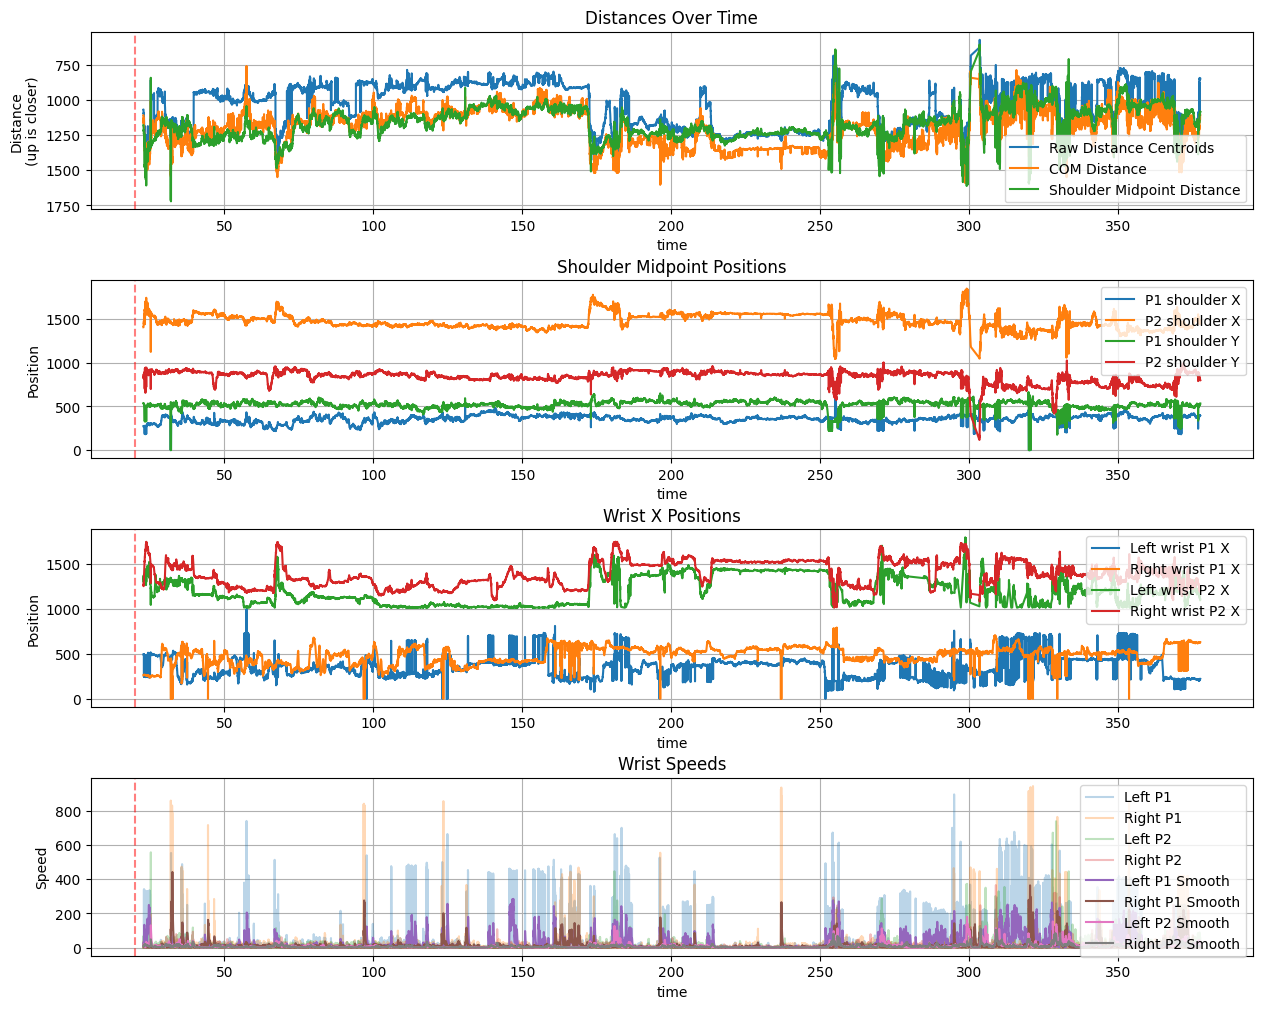

In [6]:
# plot the distance
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import cv2

# Load a sample CSV file with distance data using glob
timeseries_data = pd.read_csv(outputfol + '/' + vidname + '_processed_data_layer2.csv')
# print time range and steps
print(f"Time range: {timeseries_data['time'].min()} to {timeseries_data['time'].max()} seconds")
# make a function out of this
def plot_timeseries(timeseries_data, current_time=None, figsize=(15, 12)):
     """
     Create a comprehensive visualization of motion analysis data.
     
     Parameters:
     -----------
     timeseries_data : pandas.DataFrame
          DataFrame containing all the motion analysis columns
     current_time : int, optional
          time number to mark with vertical line
     figsize : tuple, optional
          Figure size in inches (width, height)
     """
     # Create figure with subplots
     fig = plt.figure(figsize=figsize)
     
     # Define grid layout
     gs = plt.GridSpec(4, 1, height_ratios=[1, 1, 1, 1], hspace=0.4)
     
     # 1. Distance Plots
     ax1 = fig.add_subplot(gs[0])
     sns.lineplot(data=timeseries_data, x='time', y='distance', label='Raw Distance Centroids', ax=ax1)
     sns.lineplot(data=timeseries_data, x='time', y='distance_com', label='COM Distance', ax=ax1)
     sns.lineplot(data=timeseries_data, x='time', y='distance_shoulder_midpoint', label='Shoulder Midpoint Distance', ax=ax1)
     ax1.set_title('Distances Over Time')
     ax1.set_ylabel('Distance\n(up is closer)')
     ax1.grid(True)
     ax1.invert_yaxis()
     
     # 2. Shoulder Midpoint Positions
     ax2 = fig.add_subplot(gs[1])
     sns.lineplot(data=timeseries_data, x='time', y='shoulder_midpoint_p1_x', label='P1 shoulder X', ax=ax2)
     sns.lineplot(data=timeseries_data, x='time', y='shoulder_midpoint_p2_x', label='P2 shoulder X', ax=ax2)
     sns.lineplot(data=timeseries_data, x='time', y='shoulder_midpoint_p1_y', label='P1 shoulder Y', ax=ax2)
     sns.lineplot(data=timeseries_data, x='time', y='shoulder_midpoint_p2_y', label='P2 shoulder Y', ax=ax2)
     ax2.set_title('Shoulder Midpoint Positions')
     ax2.set_ylabel('Position')
     ax2.grid(True)
     
     # 3. Wrist Positions
     ax3 = fig.add_subplot(gs[2])
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p1_x', label='Left wrist P1 X', ax=ax3)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p1_x', label='Right wrist P1 X', ax=ax3)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p2_x', label='Left wrist P2 X', ax=ax3)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p2_x', label='Right wrist P2 X', ax=ax3)
     ax3.set_title('Wrist X Positions')
     ax3.set_ylabel('Position')
     ax3.grid(True)
     
     # 4. Wrist Speeds
     ax4 = fig.add_subplot(gs[3])
     # Raw speeds
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p1_speed', label='Left P1', alpha=0.3, ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p1_speed', label='Right P1', alpha=0.3, ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p2_speed', label='Left P2', alpha=0.3, ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p2_speed', label='Right P2', alpha=0.3, ax=ax4)
     # Smoothed speeds
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p1_speed_smooth', label='Left P1 Smooth', ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p1_speed_smooth', label='Right P1 Smooth', ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p2_speed_smooth', label='Left P2 Smooth', ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p2_speed_smooth', label='Right P2 Smooth', ax=ax4)
     ax4.set_title('Wrist Speeds')
     ax4.set_ylabel('Speed')
     ax4.grid(True)
     
     # Add vertical line for current time if specified
     if current_time is not None:
          for ax in [ax1, ax2, ax3, ax4]:
                ax.axvline(x=current_time, color='r', linestyle='--', alpha=0.5)
     
     # Set common x-label
     plt.xlabel('time')
     
     # Adjust layout
     plt.tight_layout()
     
     return fig


test = plot_timeseries(timeseries_data, 20)


Note of course, that is is now not difficult to just load a file and compute summary statistics for this particular video (or trial). 

the mean distance: 1033.867948561163
standard deviation:  154.9236293412241


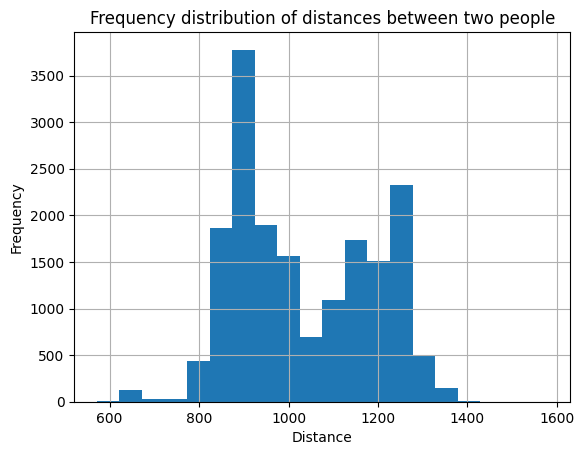

In [7]:
import pandas as pd
from scipy.integrate import simpson as simps
# note that you should run the following command if you have scipy version > 1.13
# from scipy.integrate import simps

# Load a CSV file with distance data using glob
timeseries_data = pd.read_csv(glob.glob(outputfol + '*processed_data*.csv')[0])

# computing some relevant summary statistcs (mean, sd, and frequency distribution)
mean_distance = timeseries_data['distance'].mean()
sd_distance = timeseries_data['distance'].std()
timeseries_data['distance'].plot.hist(bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Frequency distribution of distances between two people')
plt.grid()
print('the mean distance:',  mean_distance)
print('standard deviation: ', sd_distance)

In [8]:
# specifically we might be interested in computing the smoothness of the distance

def dimensionless_squared_jerk_from_speed(distance, time):
     """
     Calculate the dimensionless squared jerk metric from speed data.
     
     Parameters:
     -----------
     distance : array_like
          Distance data points (first derivative of position), should be a 1D numpy array
     time : array_like
          Time points corresponding to the distance data, should be a 1D numpy array
     
     Returns:
     --------
     float
          Dimensionless squared jerk metric
     """
     # Calculate the time step
     dt = np.diff(time)[0]
     
     speed = np.gradient(distance, dt)

     # Calculate acceleration (first derivative of speed)
     acceleration = np.gradient(speed, dt)
     
     # Calculate jerk (second derivative of speed)
     jerk = np.gradient(acceleration, dt)
     
     # Calculate movement duration (D)
     movement_duration = time[-1] - time[0]
     
     # Calculate movement amplitude by integrating speed to get distance
     position = simps(speed, x=time)  # Total distance traveled
     movement_amplitude = position  # In this case, amplitude is total distance
     
     # Calculate the squared jerk
     squared_jerk = jerk ** 2
     
     # Integrate the squared jerk
     integrated_squared_jerk = simps(squared_jerk, x=time)
     
     # Calculate the dimensionless squared jerk
     dimensionless_jerk = integrated_squared_jerk * (movement_duration**5 / movement_amplitude**2)
     
     return dimensionless_jerk

# Calculate the dimensionless squared jerk for the distance data and print
dimensionless_jerk = dimensionless_squared_jerk_from_speed(timeseries_data['distance_smooth'].values, timeseries_data['time'].values)
print('Dimensionless squared jerk:', dimensionless_jerk)

Dimensionless squared jerk: 1.6617281525262826e+21


In the following chunk, we loop over each time of the tracked video, and then we generate a figure with the vertical bar at the precise time number, and plot the timeseries plot onto the video (in the lower region). In this way we can show the changing social proximity.

In [9]:
import tqdm
import tempfile

#check all videos with layer 1
inputfol = '../data_sampledatatracked_afterSTEP1/'
allvidsnew = glob.glob(inputfol + '*_layer1.mp4')

# make an annimation
for vids in allvidsnew:
     vidname = os.path.basename(vids)
     # remove substring "_annotated_layer1"
     lab = "_annotated_layer1"
     vidname = vidname.replace(lab, "")     
     vidname = vidname[:-4]
     
          # Load the CSV file
     timeseries_data = pd.read_csv(outputfol + '/' + vidname + '_processed_data_layer2.csv')
     # load the video file in opencv
     cap = cv2.VideoCapture(vids)
     # Get video properties
     fps = int(cap.get(cv2.CAP_PROP_FPS))
     width = int(cap.get(cv2.CAP_PROP_time_WIDTH))
     height = int(cap.get(cv2.CAP_PROP_time_HEIGHT))
     # Define the output video writer
     output_path = outputfol + '/' + vidname + '_distance_layer2.mp4'
     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
     out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
     # loop over the times with tqdm processbar
     time_count = 0
     for _ in tqdm.tqdm(range(int(cap.get(cv2.CAP_PROP_time_COUNT)))):
          # read the time
          success, time = cap.read()
          if not success:
                break
          # plot the distance
          plot = plot_timeseries(timeseries_data, time_count)
          # save the plot to a temp file in the output folder
          with tempfile.NamedTemporaryFile(suffix='.png', delete=False, dir=outputfol) as f:          
                plot.savefig(f.name)
                slice_start = 2 * (height // 3)
                slice_height = time.shape[0] - slice_start

                # Resize dynamically
                plot_img = cv2.resize(plot_img, (width, slice_height))

                # Assign without shape mismatch
                time[slice_start:slice_start + slice_height, :, :] = plot_img
               

                # write the time to the output video
                # downsize the video by a half
                out.write(time)
                      
          time_count += 1
     # Release everything
     cap.release()
     out.release()
     print(f"Output video saved as {output_path}")
     # delete all temp files
     for file in glob.glob(outputfol + '/*.png'):
          os.remove(file)

AttributeError: module 'cv2' has no attribute 'CAP_PROP_time_WIDTH'